In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd
from catboost import CatBoostClassifier
import numpy as np

In [10]:
# get data from csv file on desktop
data = pd.read_csv(r'C:\Users\Alex\Desktop\data_sample_10.csv')

In [11]:
data.head()

,timestamp,user_id,post_id,target,age,text_length,views,likes,like_percentage,average_likes,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,1639652406,46490,1,0,35,324,8508,1067,0.013002,1216.625181,True,False,False,False,False,False,False
1,1637521638,151675,1,0,26,324,8508,1067,0.013002,1216.625181,True,False,False,False,False,False,False
2,1635116209,51080,1,1,27,324,8508,1067,0.013002,1216.625181,True,False,False,False,False,False,False
3,1637512303,15445,1,0,24,324,8508,1067,0.013002,1216.625181,True,False,False,False,False,False,False
4,1639863458,79741,1,0,21,324,8508,1067,0.013002,1216.625181,True,False,False,False,False,False,False


In [14]:
user_ids = data['user_id'].unique()

# shuffle user ids
np.random.shuffle(user_ids)

# split user ids into train and test
train_user_ids = user_ids[:int(len(user_ids) * 0.8)]

# split data into train and test
train_df = data[data['user_id'].isin(train_user_ids)]
test_df = data[~data['user_id'].isin(train_user_ids)]

# split train and test into X and y
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

In [16]:
# Установка двух столбцов в качестве индексов
data.set_index(['user_id', 'post_id'], inplace=True)

KeyError: "None of ['user_id', 'post_id'] are in the columns"

In [17]:
cat_features = ['topic_business', 'topic_covid',
       'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport',
       'topic_tech']

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=200,  # Modify this parameter as needed
    thread_count=8,  
    eval_metric='PRAUC',  # Changed to PR AUC
    verbose=100,  # Output the training process every 200 iterations
    random_seed=42
)

# Fit model
model.fit(X_train, y_train, cat_features=cat_features ,eval_set=(X_test, y_test))


Learning rate set to 0.5
0:	learn: 0.1706499	test: 0.1705539	best: 0.1705539 (0)	total: 404ms	remaining: 1m 20s
100:	learn: 0.1611638	test: 0.1579089	best: 0.1705539 (0)	total: 1m 7s	remaining: 1m 5s
199:	learn: 0.1654431	test: 0.1575531	best: 0.1705539 (0)	total: 2m 17s	remaining: 0us

bestTest = 0.1705539361
bestIteration = 0

Shrink model to first 1 iterations.


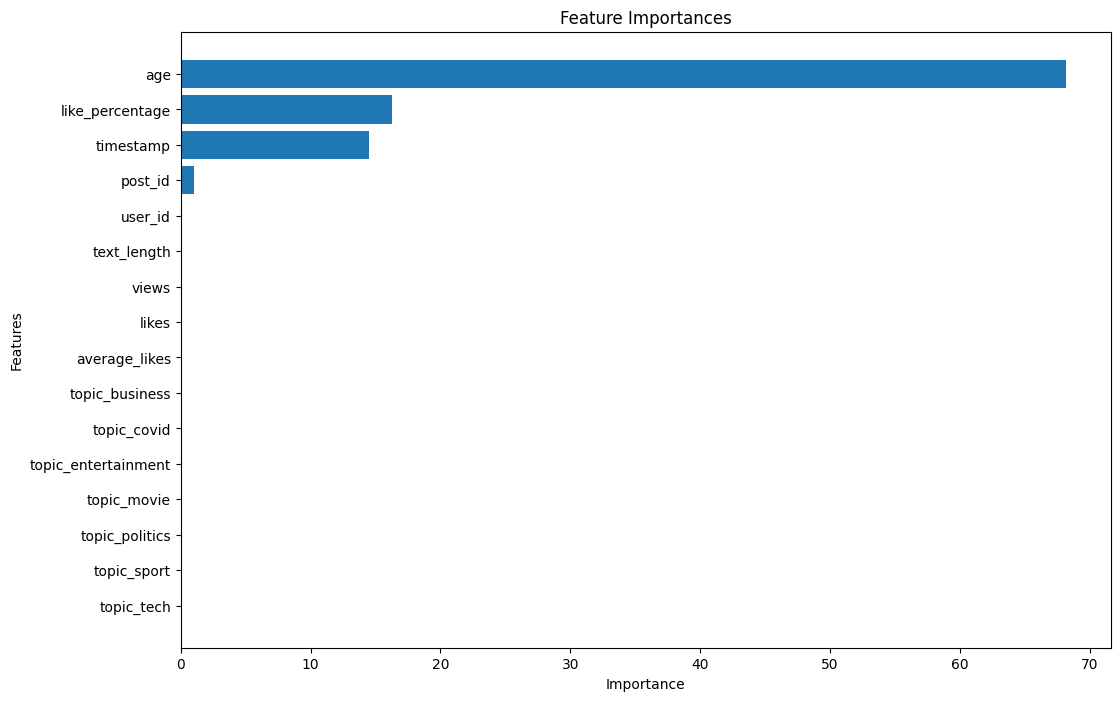

In [19]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()



In [16]:
def hitrate5(model, X, Y):
    check = pd.concat([Y,
                       pd.Series(model.predict_proba(X)[:,1], index=Y.index, name='probas')],
                      axis=1)
    check = check.reset_index().drop(columns='post_id')
    
    pred_list = [check[check.user_id == user_id].sort_values('probas', ascending=False).iloc[:5]
                 for user_id in check.user_id.unique()]

    return pd.concat(pred_list).groupby('user_id').target.sum().map(lambda x: min(1, x)).mean()

# x, y - это выборка из 2000 пользователей с их feed_data
print('Hitrate@5: {:.4f}'.format(hitrate5(model, X_test, y_test)))

Hitrate@5: 0.4659
